# Extensive Exploratory Data Analysis


This will be a notebook focused only for exploratory data analysis. My goal here is to build a better intuition about the given data, possible problems, validate some features to check their consistency as well as if they are correlated with our target variable.

In [1]:
import warnings
import math
import re

import pandas as pd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np

warnings.filterwarnings("ignore")
plt.rcParams.update({'font.size': 80})

%load_ext autoreload
%autoreload 2
%run ../src/utils.py

In [2]:
train = pd.read_csv('../data/raw/data_train.zip', index_col='Unnamed: 0', low_memory=True)
train.shape

(814262, 11)

In [3]:
test = pd.read_csv('../data/raw/data_test.zip', index_col='Unnamed: 0', low_memory=True)
test.shape

(202937, 11)

In [4]:
idx_limit = train.shape[0]

In [5]:
data = pd.concat([train, test], axis=0)

In [6]:
# temporal features

# transforming time variable to timedelta format in pandas
data['minute_entry'] = data.time_entry.apply(lambda x: int(x.split(':')[1]))
data['minute_exit'] = data.time_exit.apply(lambda x: int(x.split(':')[1]))

data['hour_entry'] = data.time_entry.apply(lambda x: int(x.split(':')[0]))
data['hour_exit'] = data.time_exit.apply(lambda x: int(x.split(':')[0]))

data['time_entry'] = pd.to_timedelta(data.time_entry)
data['time_exit'] = pd.to_timedelta(data.time_exit)

In [7]:
data['trajectory_number'] = data.trajectory_id.apply(lambda x: int(re.findall('_\d+$', x)[0].strip('_')))

In [8]:
data.isnull().sum(axis=0) / data.shape[0]

hash                 0.000000
trajectory_id        0.000000
time_entry           0.000000
time_exit            0.000000
vmax                 0.693792
vmin                 0.693792
vmean                0.677411
x_entry              0.000000
y_entry              0.000000
x_exit               0.032948
y_exit               0.032948
minute_entry         0.000000
minute_exit          0.000000
hour_entry           0.000000
hour_exit            0.000000
trajectory_number    0.000000
dtype: float64

In [9]:
import pyproj

converter = pyproj.Proj("+proj=merc +lat_ts=0 +lat_0=0 +lon_0=0 +x_0=0 \
                    +y_0=0 +ellps=WGS84 +datum=WGS84 +units=m +no_defs")

data['lat_lon_entry'] = [converter(x, y, inverse=True) for x, y in zip(data.x_entry, data.y_entry)]

data['lat_entry'] = data.lat_lon_entry.apply(lambda row: row[0])
data['lon_entry'] = data.lat_lon_entry.apply(lambda row: row[1])

data['lat_lon_exit'] = [converter(x, y, inverse=True) for x, y in zip(data.x_exit, data.y_exit)]

data['lat_exit'] = data.lat_lon_exit.apply(lambda row: row[0])
data['lon_exit'] = data.lat_lon_exit.apply(lambda row: row[1])

## 1. Features

First of all, our interest is to know when an id/person will be inside the center city, let's then define the variables related to that.

In [10]:
data['euclidean_distance'] = euclidean(data.x_entry.values, data.y_entry.values, 
                                       data.x_exit.values, data.y_exit.values)

data['manhattan_distance'] = manhattan(data.x_entry.values, data.y_entry.values, 
                                       data.x_exit.values, data.y_exit.values)

data['harvesine_distance'] = haversine(data.lon_entry.values, data.lat_entry.values, 
                                       data.lon_exit.values, data.lat_exit.values)

Let's see the relationship between haversine and euclidean distances.

As we can see, a lot of trajectories has a zero traveled distance. That could be some kind of bug, or misreading of sensor data.

Let's see how our the distance to the city center is ditributed during along the day, that is, what is the average distance traveled by time?

In [11]:
def is_inside_city(x, y):
    if (center['x_min'] <= x <= center['x_max']) and (center['y_min'] <= y <= center['y_max']):
        return 1
    else:
        return 0

data['is_inside_city_entry'] = [is_inside_city(x, y) for x, y in zip(data.x_entry, data.y_entry)]
data['is_inside_city_exit']  = [is_inside_city(x, y) for x, y in zip(data.x_exit, data.y_exit)]

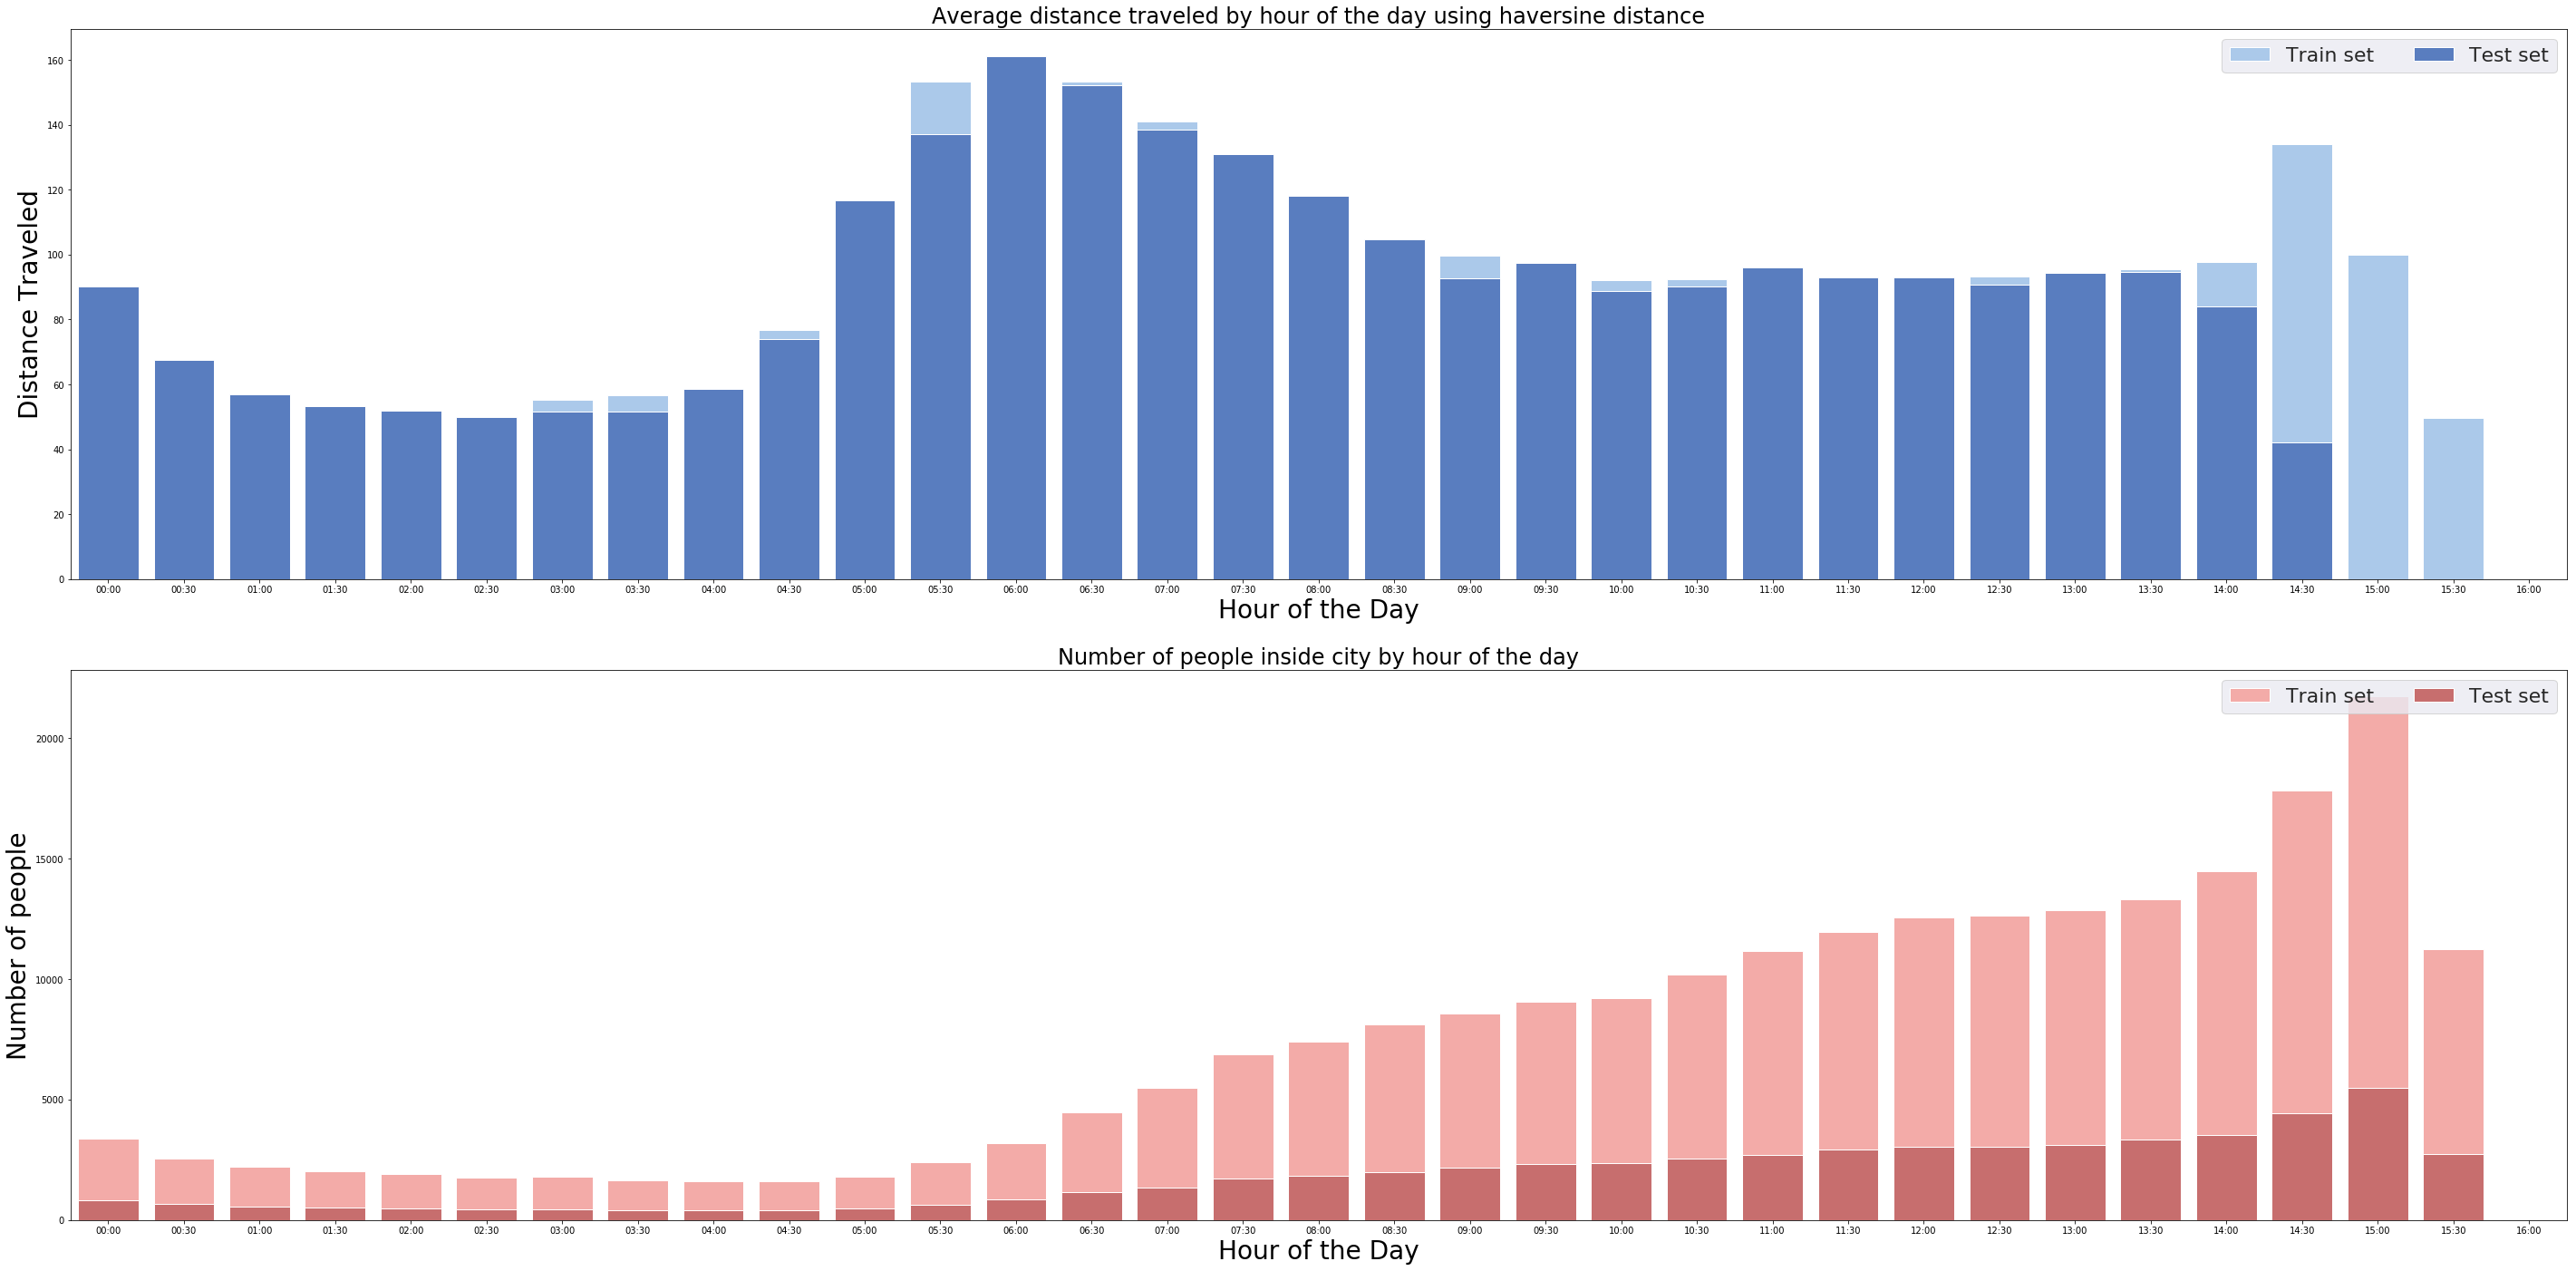

In [12]:
fig, ax = plt.subplots(2, 1, figsize=(40, 20))

# test average traveled distance for time of day in train set
entry_avg = data[:idx_limit].set_index('time_entry').harvesine_distance.resample('0.5H').mean()
entry_avg_test = data[idx_limit:].set_index('time_entry').harvesine_distance.resample('0.5H').mean()

new_idx = [time.strftime('%H:%M') for time in pd.to_datetime(entry_avg.index)]

entry_avg.index = new_idx
entry_avg_test.index = new_idx

sns.set(font_scale = 1.5)
#sns.set(style="whitegrid", palette='dark', color_codes=False)
sns.set_color_codes("pastel")
sns.barplot(x='index', 
                 y='harvesine_distance', 
                 data=entry_avg.to_frame().reset_index(), 
                 ax=ax[0], 
                 color='b', 
                 label="Train set",
                 alpha=1)

sns.set_color_codes("muted")
sns.barplot(x='index', 
                 y='harvesine_distance', 
                 data=entry_avg_test.to_frame().reset_index(), 
                 ax=ax[0], 
                 color='b',
                 label="Test set",
                 alpha=1)

entry_avg = data[:idx_limit].set_index('time_entry').is_inside_city_entry.resample('0.5H').sum()
entry_avg_test = data[idx_limit:].set_index('time_entry').is_inside_city_entry.resample('0.5H').sum()

new_idx = [time.strftime('%H:%M') for time in pd.to_datetime(entry_avg.index)]

entry_avg.index = new_idx
entry_avg_test.index = new_idx

sns.set(font_scale = 2)
#sns.set(style="whitegrid", palette='dark', color_codes=False)
sns.set_color_codes("pastel")
sns.barplot(x='index', 
                 y='is_inside_city_entry', 
                 data=entry_avg.to_frame().reset_index(), 
                 ax=ax[1], 
                 color='r', 
                 label="Train set",
                 alpha=1)

sns.set_color_codes("muted")
sns.barplot(x='index', 
                 y='is_inside_city_entry', 
                 data=entry_avg_test.to_frame().reset_index(), 
                 ax=ax[1], 
                 color='r',
                 label="Test set",
                 alpha=1)

ax[0].legend(ncol=2, loc="upper right", frameon=True)
ax[0].set_ylabel('Distance Traveled', fontsize=28)
ax[0].set_xlabel('Hour of the Day', fontsize=28)
ax[0].set_title('Average distance traveled by hour of the day using haversine distance')


ax[1].legend(ncol=2, loc="upper right", frameon=True)
ax[1].set_ylabel('Number of people', fontsize=28)
ax[1].set_xlabel('Hour of the Day', fontsize=28)
ax[1].set_title('Number of people inside city by hour of the day')

plt.tight_layout()  
#for tick in ax[1].get_xticklabels():
#    tick.set_rotation(45)

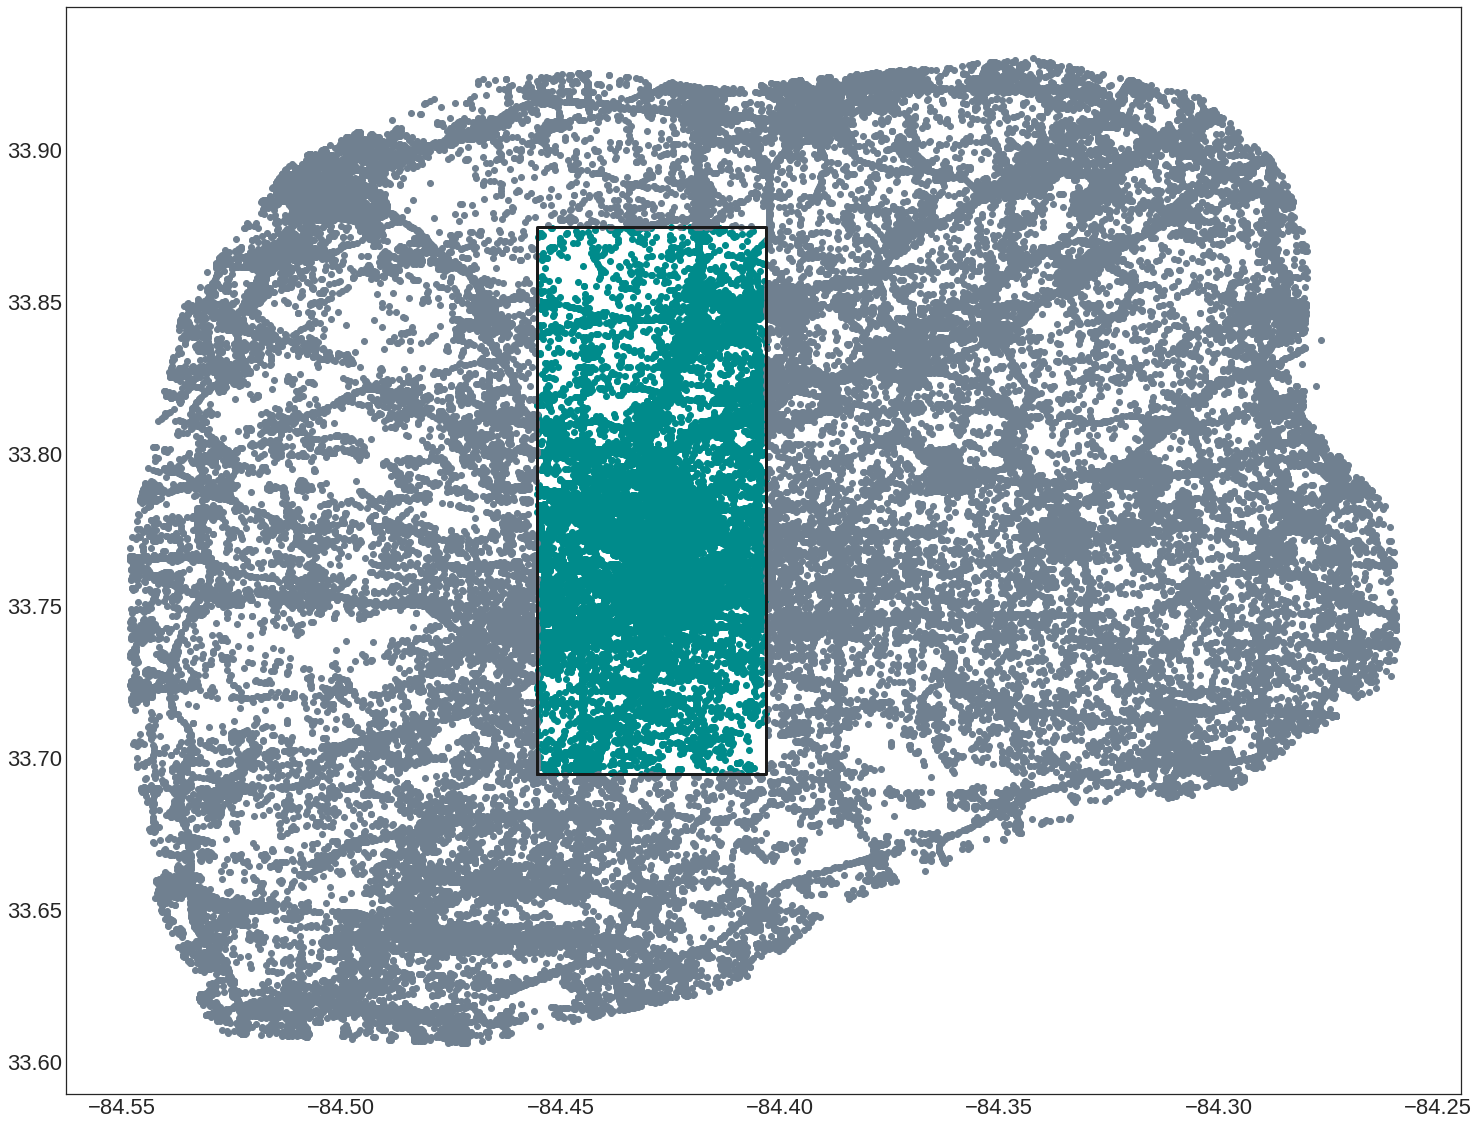

In [14]:
plt.style.use('seaborn-white')
fig, ax = plt.subplots(figsize=(25, 20))

x_1, y_1 = center_polygon_latlon.exterior.xy
plt.plot(x_1, y_1, color='k', alpha=1,
        linewidth=3, solid_capstyle='round', zorder=2)
    
df = data[(data.x_exit.notnull()) & (data.time_exit > pd.to_timedelta('15:00:00'))].copy()

df_inside = df[df.is_inside_city_entry==1]
df_outside = df[df.is_inside_city_entry==0]

plt.scatter(df_inside.lon_entry, df_inside.lat_entry, color='darkcyan')
plt.scatter(df_outside.lon_entry, df_outside.lat_entry, color='slategray')

#ax.set_axis_off()
plt.show()

In [15]:
entry_avg.nlargest(15)

15:00    21755
14:30    17838
14:00    14470
13:30    13329
13:00    12855
12:30    12622
12:00    12573
11:30    11957
15:30    11250
11:00    11169
10:30    10182
10:00     9195
09:30     9074
09:00     8573
08:30     8137
Name: is_inside_city_entry, dtype: int64

We can see that we have two peaks during the day: one around 06:00-07:00 and another starting aroung 13:00 that is increasing until 15:00, the time limit we have in our dataset.

Let's do the same plot for the test set.

Minimum value for time_entry: 0 days 00:00:00
Maximum value for time_entry: 0 days 16:00:00
Minimum value for time_exit: 0 days 00:00:00
Maximum value for time_exit: 0 days 16:00:00


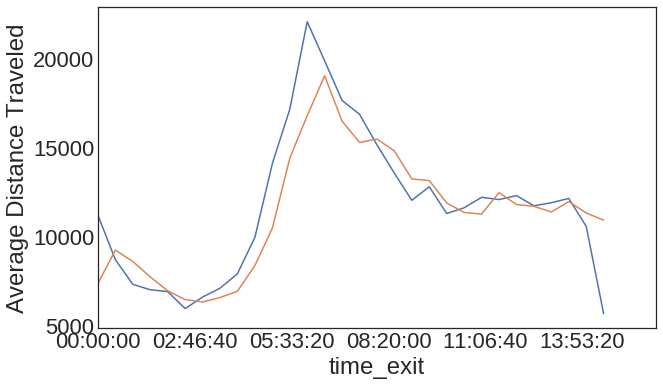

In [17]:
# test average traveled distance for time of day in test set

print('Minimum value for time_entry: {}'.format(data[idx_limit:].time_entry.min()))
print('Maximum value for time_entry: {}'.format(data[idx_limit:].time_entry.max()))

print('Minimum value for time_exit: {}'.format(data[idx_limit:].time_entry.min()))
print('Maximum value for time_exit: {}'.format(data[idx_limit:].time_entry.max()))

entry_avg = data[idx_limit:].set_index('time_entry').euclidean_distance.resample('0.5H').mean()
exit_avg = data[idx_limit:].set_index('time_exit').euclidean_distance.resample('0.5H').mean()


ax = plt.subplot(2, 1, 1)
ax.set_ylabel('Average Distance Traveled')
ax.set_xlabel('Time')

entry_avg.plot(ax=ax, figsize=(10, 13))
exit_avg.plot(ax=ax, figsize=(10, 13))

Again, we see the same pattern. Of course, the data aroung 15:00-16:00 is not available, that is why we do not have a peak at the right end of the graphic as we had with train data.

We can define a feature saying if a person is either inside city or not.

Now let's investigate the distribution of people inside city during the day.

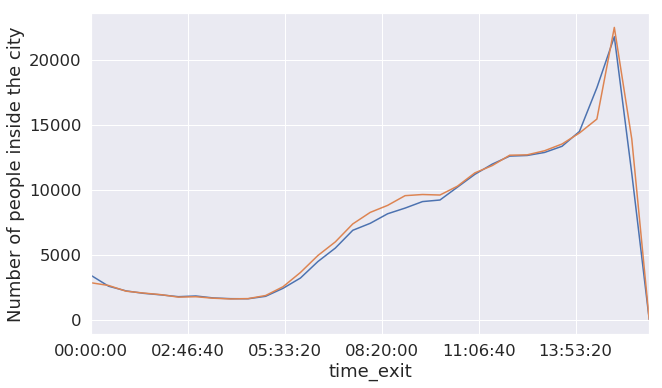

In [153]:
entry_avg_inside = data[:idx_limit].set_index('time_entry').resample('0.5H').is_inside_city_entry.sum()
exit_avg_inside = data[:idx_limit].set_index('time_exit').resample('0.5H').is_inside_city_exit.sum()

ax = plt.subplot(2, 1, 1)
ax.set_ylabel('Number of people inside the city')
ax.set_xlabel('Time')

entry_avg_inside.plot(ax=ax, figsize=(10, 13))
exit_avg_inside.plot(ax=ax, figsize=(10, 13))

In [154]:
entry_avg_inside.nlargest(10)

time_entry
15:00:00    21755
14:30:00    17838
14:00:00    14470
13:30:00    13329
13:00:00    12855
12:30:00    12622
12:00:00    12573
11:30:00    11957
15:30:00    11250
11:00:00    11169
Name: is_inside_city_entry, dtype: int64

Here we have an interesting pattern: as the hour passes, we have more people inside the city, with a peak around 15:00. Let's see better how this variable changes during the time interval of interest: 15:00-16:00.

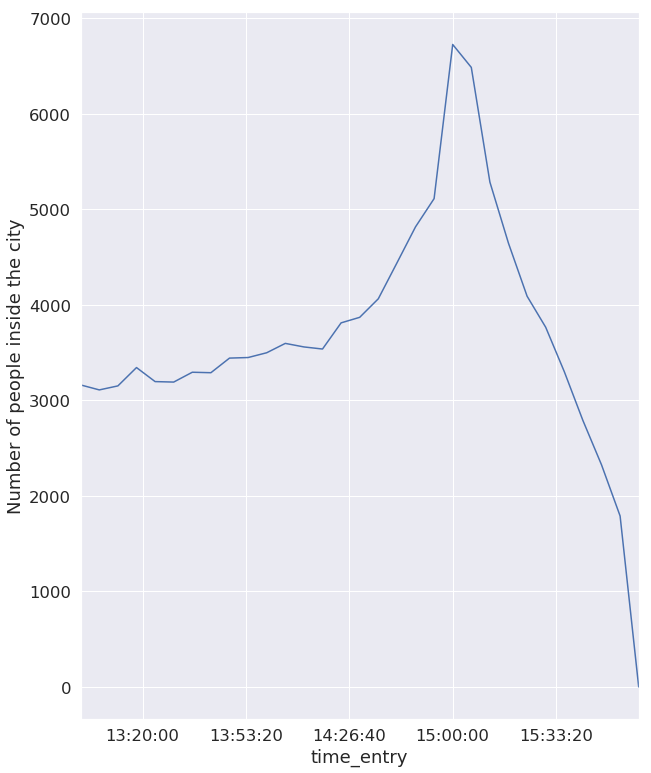

In [155]:
entry_avg_inside = (data[data.time_entry > pd.to_timedelta('13:00:00')][:idx_limit]
                    .set_index('time_entry')
                    .resample('0.1H')
                    .is_inside_city_entry
                    .sum())

ax = plt.subplot()
ax.set_ylabel('Number of people inside the city')
ax.set_xlabel('Time')

entry_avg_inside.plot(ax=ax, figsize=(10, 13))

In [156]:
entry_avg_inside.nlargest(5)

time_entry
15:00:01    6727
15:06:01    6487
15:12:01    5286
14:54:01    5113
14:48:01    4817
Name: is_inside_city_entry, dtype: int64

Here another pattern: Around 15:00 exactly we have a peak in the number of people inside city center that is decreasing up to 16:00.

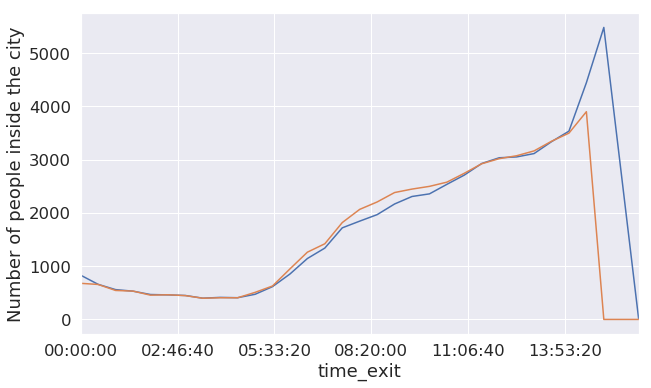

In [157]:
entry_avg_inside = data[idx_limit:].set_index('time_entry').resample('0.5H').is_inside_city_entry.sum()
exit_avg_inside = data[idx_limit:].set_index('time_exit').resample('0.5H').is_inside_city_exit.sum()


ax = plt.subplot(2, 1, 1)
ax.set_ylabel('Number of people inside the city')
ax.set_xlabel('Time')

entry_avg_inside.plot(ax=ax, figsize=(10, 13))
exit_avg_inside.plot(ax=ax, figsize=(10, 13))

Which time people usually change from inside to outside or otherwise?

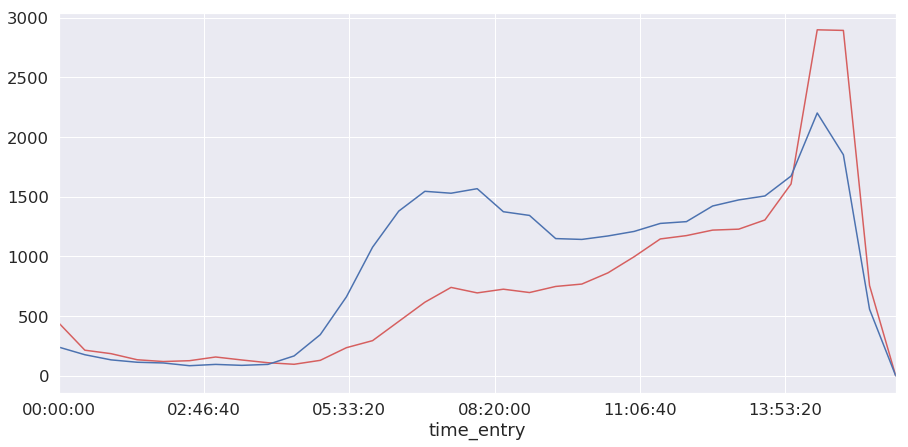

In [158]:
data['entering_city'] = data.is_inside_city_entry - data.is_inside_city_exit
data['entering_city'] = data['entering_city'].apply(lambda x: 1 if x == -1 else 0)

data['leaving_city'] = data.is_inside_city_entry - data.is_inside_city_exit
data['leaving_city'] = data['leaving_city'].apply(lambda x: 1 if x == 1 else 0)

entering_avg_inside = data[:idx_limit].set_index('time_entry').resample('0.5H').entering_city.sum()
leaving_avg_inside = data[:idx_limit].set_index('time_entry').resample('0.5H').leaving_city.sum()


fig, ax = plt.subplots(figsize=(15, 7))

leaving_avg_inside.plot(ax=ax, color='r', label='leaving')
entering_avg_inside.plot(ax=ax)

Text(0.5, 1.0, 'Number of people entering city')

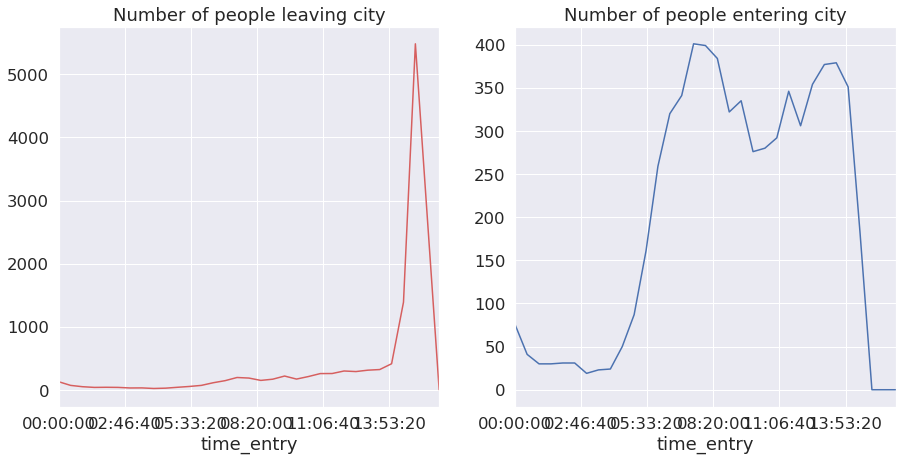

In [159]:
entering_avg_inside = data[idx_limit:].set_index('time_entry').resample('0.5H').entering_city.sum()
leaving_avg_inside = data[idx_limit:].set_index('time_entry').resample('0.5H').leaving_city.sum()


fig, ax = plt.subplots(1, 2, figsize=(15, 7))

leaving_avg_inside.plot(ax=ax[0], color='r', label='leaving')
entering_avg_inside.plot(ax=ax[1])

ax[0].set_title('Number of people leaving city')
ax[1].set_title('Number of people entering city')

Number of people leaving city between 15 and 16: 15570


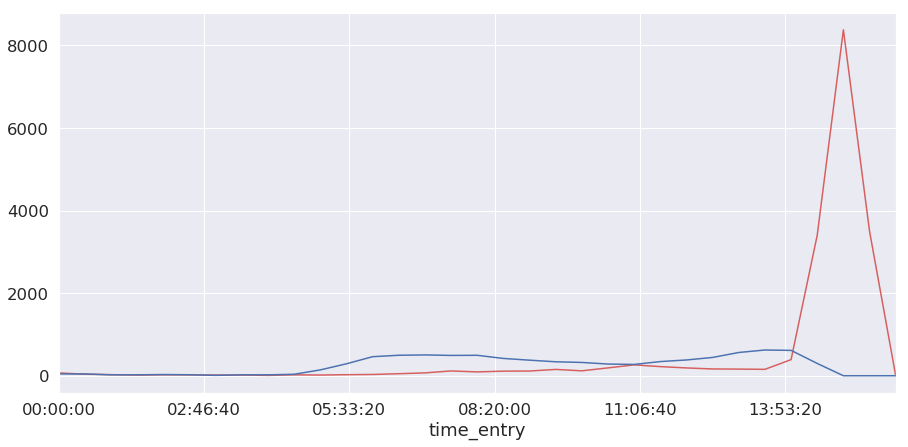

In [160]:
entry_ref = pd.to_timedelta('15:00:00')
exit_ref = pd.to_timedelta('16:00:00')

leaving_city = data[(data.time_exit >= entry_ref) & (data.time_exit <= exit_ref)]
leaving_city = leaving_city[(leaving_city.is_inside_city_entry==1) & (leaving_city.is_inside_city_exit==0)]
print("Number of people leaving city between 15 and 16: {}".format(leaving_city.shape[0]))

hashs = list(leaving_city.hash.unique())
entering_avg_inside = data[data.hash.isin(hashs)].set_index('time_entry').resample('0.5H').entering_city.sum()
leaving_avg_inside = data[data.hash.isin(hashs)].set_index('time_entry').resample('0.5H').leaving_city.sum()


fig, ax = plt.subplots(figsize=(15, 7))

leaving_avg_inside.plot(ax=ax, color='r', label='leaving')
entering_avg_inside.plot(ax=ax)

#ax[0].set_title('Number of people leaving city')
#ax[1].set_title('Number of people entering city')

In [161]:
pd.concat([leaving_avg_inside.nlargest(10), entering_avg_inside.nlargest(10)], axis=1)

,leaving_city,entering_city
time_entry,,
06:00:00,NaN,461.0
06:30:00,NaN,496.0
07:00:00,NaN,504.0
07:30:00,NaN,492.0
08:00:00,NaN,495.0
08:30:00,NaN,419.0
10:30:00,190.0,NaN
11:00:00,263.0,NaN
11:30:00,221.0,NaN


Number of people entering city between 15 and 16: 3957


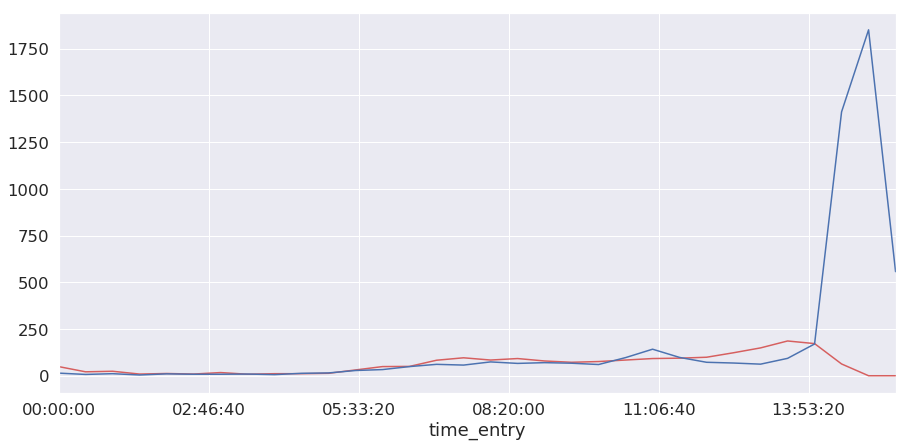

In [162]:
entry_ref = pd.to_timedelta('15:00:00')
exit_ref = pd.to_timedelta('16:00:00')

entering_city = data[(data.time_exit >= entry_ref) & (data.time_exit <= exit_ref)]
entering_city = entering_city[(entering_city.is_inside_city_entry==0) & (entering_city.is_inside_city_exit==1)]
print("Number of people entering city between 15 and 16: {}".format(entering_city.shape[0]))

hashs = list(entering_city.hash.unique())
entering_avg_inside = data[data.hash.isin(hashs)].set_index('time_entry').resample('0.5H').entering_city.sum()
leaving_avg_inside = data[data.hash.isin(hashs)].set_index('time_entry').resample('0.5H').leaving_city.sum()


fig, ax = plt.subplots(figsize=(15, 7))

leaving_avg_inside.plot(ax=ax, color='r', label='leaving')
entering_avg_inside.plot(ax=ax)

Number of people staying in city between 15 and 16: 32423


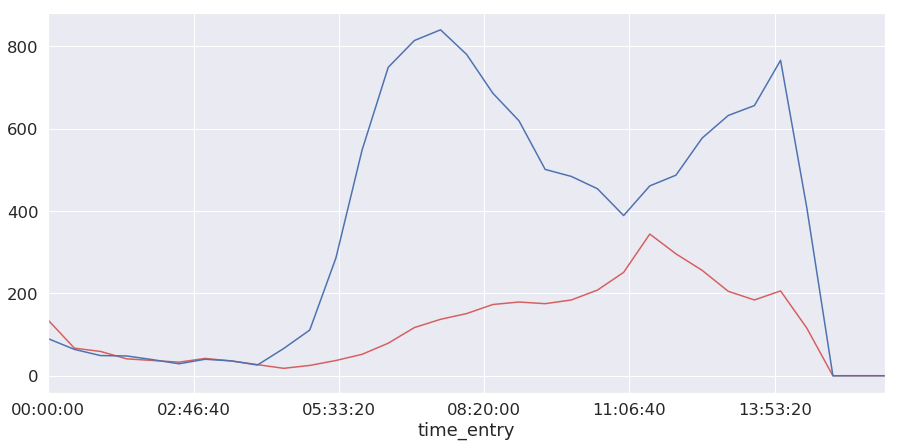

In [163]:
entry_ref = pd.to_timedelta('15:00:00')
exit_ref = pd.to_timedelta('16:00:00')

staying_city = data[(data.time_exit >= entry_ref) & (data.time_exit <= exit_ref)]
staying_city = staying_city[(staying_city.is_inside_city_entry==1) & (staying_city.is_inside_city_exit==1)]
print("Number of people staying in city between 15 and 16: {}".format(staying_city.shape[0]))

hashs = list(staying_city.hash.unique())
entering_avg_inside = data[data.hash.isin(hashs)].set_index('time_entry').resample('0.5H').entering_city.sum()
leaving_avg_inside = data[data.hash.isin(hashs)].set_index('time_entry').resample('0.5H').leaving_city.sum()


fig, ax = plt.subplots(figsize=(15, 7))

leaving_avg_inside.plot(ax=ax, color='r', label='leaving')
entering_avg_inside.plot(ax=ax)

Number of people leaving city between 15 and 16: 115628


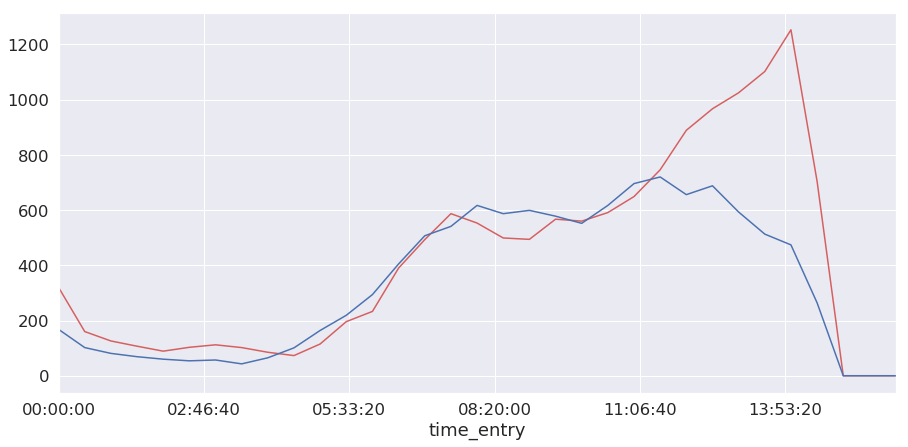

In [164]:
entry_ref = pd.to_timedelta('15:00:00')
exit_ref = pd.to_timedelta('16:00:00')

leaving_city = data[(data.time_exit >= entry_ref) & (data.time_exit <= exit_ref)]
leaving_city = leaving_city[(leaving_city.is_inside_city_entry==0) & (leaving_city.is_inside_city_exit==0)]
print("Number of people leaving city between 15 and 16: {}".format(leaving_city.shape[0]))

hashs = list(leaving_city.hash.unique())
entering_avg_inside = data[data.hash.isin(hashs)].set_index('time_entry').resample('0.5H').entering_city.sum()
leaving_avg_inside = data[data.hash.isin(hashs)].set_index('time_entry').resample('0.5H').leaving_city.sum()


fig, ax = plt.subplots(figsize=(15, 7))

leaving_avg_inside.plot(ax=ax, color='r', label='leaving')
entering_avg_inside.plot(ax=ax)

In [165]:
x_center = 3750901.5068 + ((3770901.5068-3750901.5068)/2)
y_center = -19268905.6133 + ((-19208905.6133+19268905.6133)/2)

data['distance_cc_entry'] = np.sqrt(((data.x_entry.values-x_center)**2) + ((data.y_entry.values-y_center)**2))
data['distance_cc_exit'] = np.sqrt(((data.x_exit.values-x_center)**2) + ((data.y_exit.values-y_center)**2))

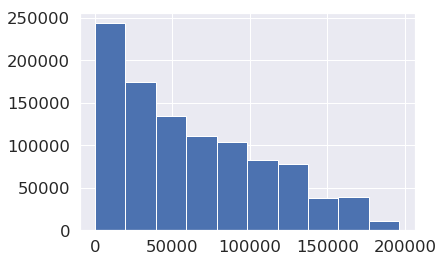

In [166]:
data['distance_cc_entry'].hist()